### Author: Helen Cai
### April 2025
The purpose of this notebook is to create an encoder architecture that will be used in our final project. 

As input, the encoder will receive graph representations. These graph representations are to be created from SMILES codes of valid molecules (e.g. insecticides and pesticides).

As output, the encoder will create low-dimensional representations of these molecules in the latent space. 

We look to GRASSY and ReLSO for inspiration on key insight that makes shaping the latent space possible. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import tqdm

# NetworkX is a Python package used to create, manipulate, and mine graphs
import networkx as nx

# further libraries for working with graphs
import torch_geometric
from torch_geometric.nn import GCNConv, pool
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

# For visualization
import phate

# Graph scattering functionality
from functions.LEGS_module import *

## Hyperparameters

In [2]:
epochs = 500
learning_rate = 1e-4
batch_size = 4
p = 0.2     # probability for dropout
smoothness_lambda = 1e-2 # for calculating composite loss

## 0. Set up some data to work with

From https://pytorch-geometric.readthedocs.io/en/2.6.1/get_started/introduction.html: 

"Initializing a dataset is straightforward. An initialization of a dataset will automatically download its raw files and process them to the previously described Data format."

**Note that in the training we are essentially performing a regression task, in which there is 1 target for the entire graph.** 

**This is where we want to grab data from Tobias.**

Expected input: dataset/dataloader where each molecule is represented by 1 graph.

Variable number of nodes is ok.

Expect target to belong in `data.y`. Since we want to regress out values of logP, we can use something like MSE to calculate loss.

/tmp/ipykernel_1182727/793744003.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pesticides = torch.load("./data/pesticides_graphs_augmented_v3.pt")


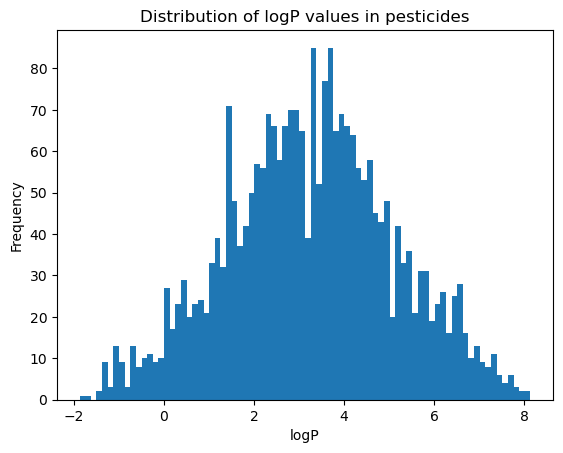

In [3]:
pesticides = torch.load("./data/pesticides_graphs_augmented_v3.pt")

# In our dataset, the target to regress is logP.
# We visualize what these values are and try to get a sense of the shape of the distribution
y_values = np.array([data.y for data in pesticides])

plt.hist(y_values, bins=80)
plt.xlabel("logP")
plt.ylabel("Frequency")
plt.title("Distribution of logP values in pesticides")
plt.show()

In [4]:
# Get some basic useful information
print([data.num_features for data in pesticides])

print(pesticides[1].y)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [5]:
# split into training and test
train_dataset, test_dataset = train_test_split(pesticides, test_size=0.2, random_state=2025)

all_data = DataLoader(pesticides, batch_size=1, shuffle = False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

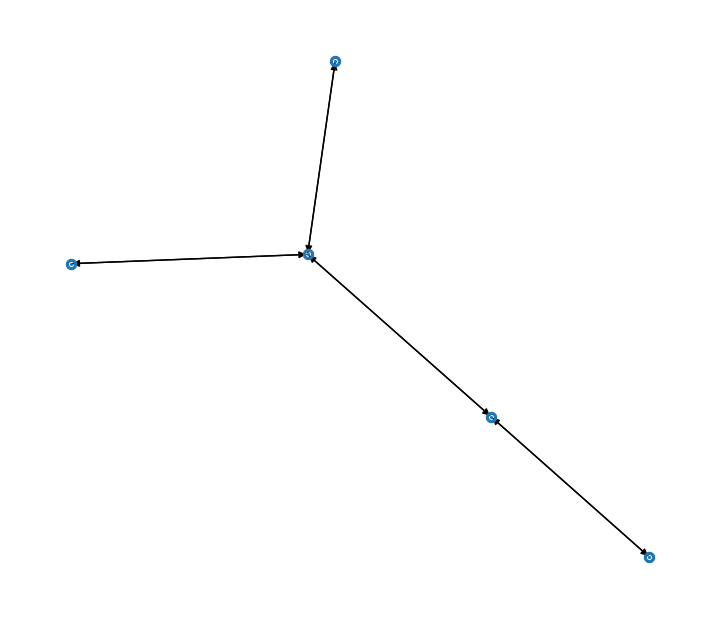

In [6]:
# visualize an example network
example_graph = to_networkx(pesticides[12])


plt.figure(1,figsize=(7,6)) 
nx.draw(example_graph, node_size=5,linewidths=6)
plt.savefig("./training-figs/encoder/sample_plot.png") 
plt.show()


## 1. Initialize a graph neural network

Note that GRASSY implementation is available here:
https://github.com/KrishnaswamyLab/GRASSY-Net/blob/main/models/GRASSY_model.py

In [7]:
class GCN(nn.Module):
    """
    Initialize a graph convolutional network
    """
    def __init__(
        self,
        num_features: int = 3, # TODO: replace this with the proper dimension
        num_classes: int = 1,
        p: float = 0.0,
    ):
        super().__init__()

        # GCNConv takes in two arguments: in_channels and out_channels
        # for now, we choose an arbitrary number of channels
        self.conv1 = GCNConv(num_features, 32)

        # GRASSY would replace the GCNConv with scattering function

        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, 16) # increase dimensionality here; can go all the way to 128

        self.linear1 = Linear(16, 16)
        self.dropout = nn.Dropout(p)
        self.embedding_layer = Linear(16, 16)
        
        self.classifier = Linear(16, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        h = self.conv1(x, edge_index)
        h = h.relu() # TODO: maybe pick a different non-linearity?
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()

        # sum pool
        h = pool.global_add_pool(h, batch)

        embedding = self.embedding_layer(h)
        
        h = embedding.relu()
        
        # last layer is a classifier
        output = self.classifier(h)

        return embedding, output 

In [8]:
class ScatterNet(nn.Module):
    """
    We improve on the graph convolutional network approach by using the graph scattering transform.
    """
    def __init__(
        self,
        num_features: int = 3, 
        num_classes: int = 1,
        p: float = 0.0,
    ):
        super().__init__()
        
        self.scatter = Scatter(num_features, trainable_laziness=False)  
    
        self.linear1 = Linear(99, 128)  # note that the output size of the scattering layer changes with the number
                                            # of moments that are calculated

        self.linear2 = Linear(128, 64)
        self.linear3 = Linear(64, 16)
        self.embedding_layer = Linear(16, 16)

        self.act = torch.nn.LeakyReLU()
        
        self.dropout = nn.Dropout(p)
        
        self.classifier = Linear(16, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        h, __ = self.scatter(data)
        h = self.act(h)  
        h = self.linear1(h)
   
        h = self.dropout(h)
        h = self.act(h)  
        h = self.linear2(h)

        h = self.dropout(h)
        h = self.act(h)  
        h = self.linear3(h)
        
        embedding = self.embedding_layer(h)
        
        h = self.act(embedding)  
        
        # last layer is a classifier
        output = self.classifier(embedding)

        return embedding, output 
        

## 2. Define train and test functions

In [9]:
def plot_metrics(train_metrics, test_metrics, xlabel, ylabel, title, fname, subdir):
    x = np.array(range(len(train_metrics))) + 1
    plt.plot(x, train_metrics, label="train")
    plt.plot(x, test_metrics, label="test")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    fname = subdir + fname
    plt.savefig(fname) 
    plt.show()

In [10]:
def train_epoch(model, loss_fn, optimizer, train_loader, embeddings_list):
    """Train the model for one epoch.
    Args:
        model: the model
        loss_fn: the loss function
        optimizer: the optimizer
    Returns:
        train_loss: the loss of the epoch
    """
    
    model.train()
    optimizer.zero_grad()
    base_loss_epoch = 0
    smoothness_loss_epoch = 0
    composite_loss_epoch = 0

    # calculate smoothness loss
    smoothness_loss = calculate_smoothness_loss(embeddings_list, k=3)
    smoothness_loss_epoch += smoothness_loss.detach().numpy()

    # evaluate on the train nodes
    for data in train_loader:
        target = data.y
        batch_size = data.num_graphs

        # get the outputs
        __, out = model(data)

        # calculate base loss (MSE)

        base_loss = loss_fn(out, target.unsqueeze(1))
        base_loss_epoch += base_loss.detach().numpy() * batch_size

        # calculate composite loss
        loss = base_loss + smoothness_lambda * smoothness_loss
        composite_loss_epoch += loss.detach().numpy() * batch_size

        loss.backward()

        # perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

    # calculate training loss for the epoch
    base_loss_epoch = base_loss_epoch / len(train_loader.dataset)
    composite_loss_epoch = composite_loss_epoch / len(train_loader.dataset)

    return base_loss_epoch, smoothness_loss_epoch, composite_loss_epoch
    

In [11]:
def test_epoch(model, loss_fn, test_loader, embeddings_list):
    """Test the model for one epoch.
    Args:
        model: the model
        loss_fn: the loss function
    Returns:
        test_loss: the loss of the epoch
    """
    model.eval()  # set model to evaluation mode

    base_loss_epoch = 0
    smoothness_loss_epoch = 0
    composite_loss_epoch = 0

    # calculate smoothness loss
    smoothness_loss = calculate_smoothness_loss(embeddings_list, k=3)
    smoothness_loss_epoch += smoothness_loss.detach().numpy()
    
    with torch.no_grad():  # disable gradient calculation

        for data in test_loader:
            target = data.y
            batch_size = data.num_graphs
        
            __, out = model(data)
            
            # calculate base loss (MSE)
            base_loss = loss_fn(out, target.unsqueeze(1))
            base_loss_epoch += base_loss.detach().numpy() * batch_size
            
            # calculate composite loss
            loss = base_loss + smoothness_lambda * smoothness_loss
            composite_loss_epoch += loss.detach().numpy() * batch_size

        # calculate test loss for the epoch
        base_loss_epoch = base_loss_epoch / len(test_loader.dataset)
        composite_loss_epoch = composite_loss_epoch / len(test_loader.dataset)
                
    return base_loss_epoch, smoothness_loss_epoch, composite_loss_epoch

In [12]:
def train(model, loss_fn, train_loader, test_loader, optimizer, epochs=5):
    """Train the model.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        test_loader: the testing data loader
        optimizer: the optimizer
        epochs: the number of epochs to train
    Returns:
        train_losses: the training losses
        test_losses: the testing losses
    """
    train_base_losses = []
    train_smoothness_losses = []
    train_composite_losses = []
    
    test_base_losses = []
    test_smoothness_losses = []
    test_composite_losses = []
    
    loop = tqdm.tqdm(range(1, epochs + 1))

    for epoch in loop:
        # get the embeddings of the latent space, in order to calculate smoothness loss
        embeddings_list = []
        
        for data in train_loader:
            embedding, __ = model(data)
            embeddings_list.append(embedding.detach().numpy())
       
        embeddings_list = torch.squeeze(torch.Tensor(np.array(embeddings_list)))
        
        embeddings_list = torch.reshape(embeddings_list, (-1, 16))

        # train the model for one epoch
        train_base_loss_epoch, train_smoothness_loss_epoch, train_composite_loss_epoch = train_epoch(model, loss_fn, optimizer, train_loader, embeddings_list)
        
        # test the model for one epoch        
        test_base_loss_epoch, test_smoothness_loss_epoch, test_composite_loss_epoch = test_epoch(model, loss_fn, test_loader, embeddings_list)

        # put into our storage vectors
        train_base_losses.append(train_base_loss_epoch)
        train_smoothness_losses.append(train_smoothness_loss_epoch)
        train_composite_losses.append(train_composite_loss_epoch)
        test_base_losses.append(test_base_loss_epoch)
        test_smoothness_losses.append(test_smoothness_loss_epoch)
        test_composite_losses.append(test_composite_loss_epoch)
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(train_loss=train_base_loss_epoch, test_loss=test_base_loss_epoch)
    
    return train_base_losses, train_smoothness_losses, train_composite_losses, test_base_losses, test_smoothness_losses, test_composite_losses

## 3. Regularize the latent space
https://arxiv.org/pdf/2201.09948

ReLSO proposes two new things: 1. negative sampling and 2. interpolative sampling regularization (e.g., we want to enforce the latent space to be smooth and interpolatable). I'll first attempt to do the latter. 

The penalty of interest seems to be:

$L_{interp} = max(0, \frac{||\hat{x_1} - \hat{x_i}|| + ||\hat{x_2} - \hat{x_1}||}{2} - ||\hat{x_1} - \hat{x_2}||)$

where $\hat{x_1}$ and $\hat{x_2}$ are nearest neighbors in space and $\hat{x_i}$ is the decoded representation of the interpolated latent point.

In [13]:
def calculate_smoothness_loss(embedding, k=3):
    """
    Calculate smoothness loss, when given a set of intermediate hidden values/embeddings.
    Input:
    embedding = set of points from the latent space. Must be detached tensor/numpy array 
    k = parameter for KNN graph clustering

    Output:
    smoothness_loss = scalar quantifying the amount of loss related to smoothness
    """   
    # construct the KNN graph
    knn = NearestNeighbors(n_neighbors = k, algorithm='auto').fit(embedding)
    distances, indices = knn.kneighbors(embedding)

    # get the interpolated latent points
    interpolated_points = []
    for i in range(len(embedding)):
        for j in range(k):
            alpha = torch.rand(1).item()
            point = alpha * embedding[i] + (1 - alpha) * embedding[indices[i, j]]
            interpolated_points.append(point)
    
    decoded_embedding_points = embedding # TODO: Decode embedding and interpolated points
    decoded_interpolated_points = interpolated_points
    
    # Calculate smoothness loss
    smoothness_loss = 0
    for i in range(len(embedding)):
        for j in range(k):
            x1 = decoded_embedding_points[indices[i, 0]]
            x2 = decoded_embedding_points[indices[i, j]]
            xi = decoded_interpolated_points[i]
            
            term1 = torch.norm(x1 - xi, p=2)
            term2 = torch.norm(x2 - xi, p=2)
            term3 = torch.norm(x1 - x2, p=2)
            
            smoothness_loss  += F.relu((term1 + term2) / 2 - term3)
    
    smoothness_loss = smoothness_loss / k
    
    return smoothness_loss


## 4. Train the model

In [15]:
model = ScatterNet(p = p)

# Define the base loss function
loss_fn = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

# Call the functions
train_base_losses, train_smoothness_losses, train_composite_losses, test_base_losses, test_smoothness_losses, test_composite_losses  = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs)

Epoch 500: 100%|██████████| 500/500 [7:45:11<00:00, 55.82s/it, test_loss=0.586, train_loss=0.355]  


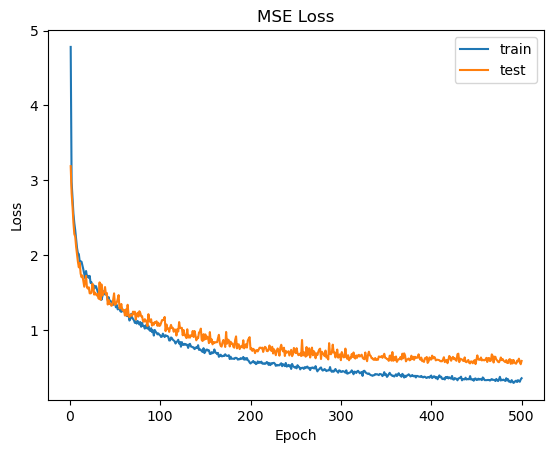

In [16]:
plot_metrics(train_base_losses, test_base_losses, 
             xlabel="Epoch", ylabel="Loss", title="MSE Loss", 
             fname="pesticide_mse_loss.png", subdir="./training-figs/encoder/")

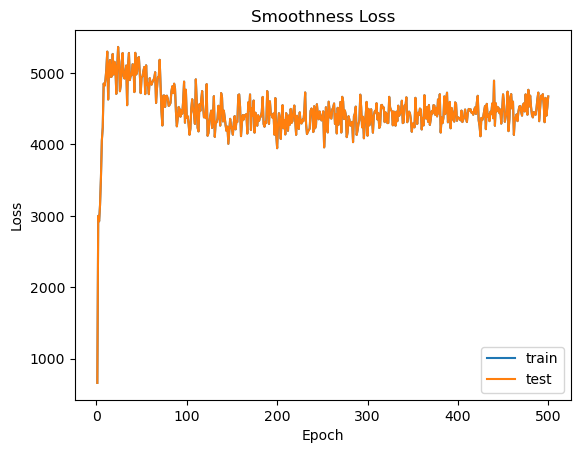

In [17]:
plot_metrics(train_smoothness_losses, test_smoothness_losses, 
             xlabel="Epoch", ylabel="Loss", title="Smoothness Loss", 
             fname="pesticide_smoothness_loss.png", subdir="./training-figs/encoder/")

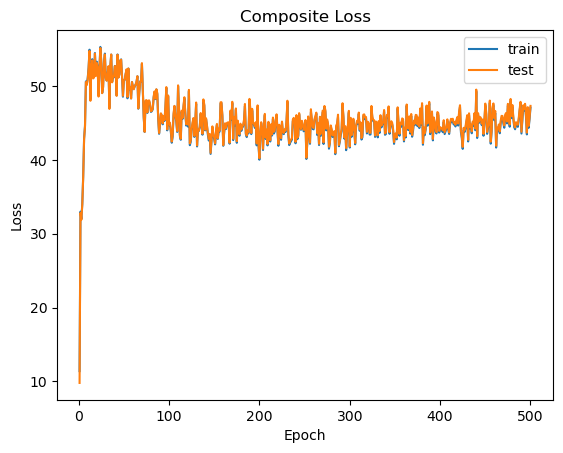

In [18]:
plot_metrics(train_composite_losses, test_composite_losses, 
             xlabel="Epoch", ylabel="Loss", title="Composite Loss", 
             fname="pesticide_composite_loss.png", subdir="./training-figs/encoder/")

## 5. Use a forward hook to get the embeddings

In [19]:
# Have the ability to get embeddings
def activation_hook(model, input, output):
    """
    model: model that we want to attach the hook to
    input: input to the 'forward' method
    output: output from the 'forward' method
    """
    hidden_values.append(np.array(output.detach()))

In [20]:
# Create a dictionary for storage
hidden_values = []
y_values = []

handle = model.embedding_layer.register_forward_hook(activation_hook)

In [21]:
for data in all_data:
    model(data)
    y_values.append(data.y)
    
# remove the hook
handle.remove()

In [22]:
print(len(all_data.dataset))
print(len(hidden_values)) # looked at the values and they appear to be duplicated x2?
print(len(y_values))


2561
2561
2561


In [23]:
# the conv layers are all of different output size since the nodes are of different number in each graph
hidden_values = torch.squeeze(torch.Tensor(np.array(hidden_values)))

print(f"Shape of hidden values: {hidden_values.shape}")

Shape of hidden values: torch.Size([2561, 16])


**This is where we will give embeddings to Jennifer.** 

Expected output: torch tensor of dimension $[(\textit{number of molecules}), (\textit{hidden dimension}=16)]$

In [24]:
torch.save(hidden_values, "./data/hidden_values_from_pesticides.pt")

In [ ]:
hidden_values = torch.load("./data/hidden_values_from_pesticides.pt", weights_only=False)

## 6. Visualize embeddings using PHATE

Following the tutorial which is available at: https://nbviewer.org/github/KrishnaswamyLab/PHATE/blob/main/Python/tutorial/EmbryoidBody.ipynb

In [25]:
# apply PHATE with hidden values
phate_operator = phate.PHATE()
Y_phate = phate_operator.fit_transform(hidden_values)

Calculating PHATE...
  Running PHATE on 2561 observations and 16 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...


/home/hsc26/.conda/envs/cpsc_452/lib/python3.12/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 519 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/hsc26/.conda/envs/cpsc_452/lib/python3.12/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 0.66 seconds.
  Calculated graph and diffusion operator in 0.78 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.15 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.18 seconds.
  Calculated landmark operator in 1.71 seconds.
  Calculating optimal t...
    Automatically selected t = 45
  Calculated optimal t in 0.79 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.30 seconds.
Calculated PHATE in 5.88 seconds.


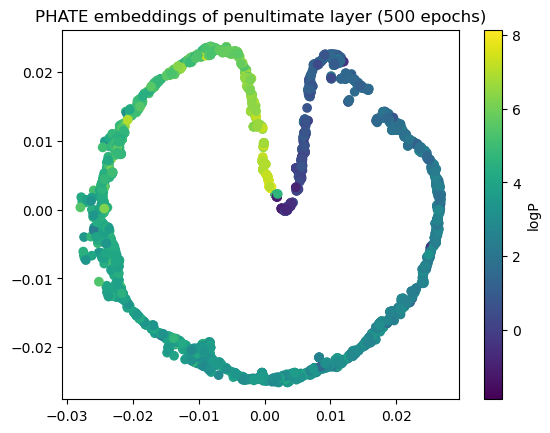

In [26]:
plt.scatter(x = Y_phate[:,0], 
            y = Y_phate[:,1],
            c = y_values, cmap = 'viridis')
plt.colorbar(label="logP")
plt.title("PHATE embeddings of penultimate layer (500 epochs)")
plt.savefig("./training-figs/encoder/pesticide_hidden_values_PHATE-500_epochs.png") 
plt.show()

## 7. Save the model

In [27]:
torch.save(model.state_dict(), "./models/ScatterNet-trained.pth")